# MNIST Classification with Falkon

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import torch
import torchvision

import falkon

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


## Download the MNIST dataset & load it in memory

In [2]:
mnist_train_dataset = torchvision.datasets.MNIST(
    root=".", train=True, download=True,
    transform=torchvision.transforms.ToTensor())
mnist_test_dataset = torchvision.datasets.MNIST(
    root=".", train=False, download=True,
    transform=torchvision.transforms.ToTensor())

In [3]:
# Load the whole dataset in memory
mnist_tr_img_list, mnist_tr_label_list = [], []
for i in range(len(mnist_train_dataset)):
    data_point = mnist_train_dataset[i]
    mnist_tr_img_list.append(data_point[0])
    mnist_tr_label_list.append(data_point[1])
mnist_ts_img_list, mnist_ts_label_list = [], []
for i in range(len(mnist_test_dataset)):
    data_point = mnist_test_dataset[i]
    mnist_ts_img_list.append(data_point[0])
    mnist_ts_label_list.append(data_point[1])

In [4]:
mnist_tr_x = torch.vstack(mnist_tr_img_list)
mnist_tr_x = mnist_tr_x.reshape(mnist_tr_x.shape[0], -1)
mnist_ts_x = torch.vstack(mnist_ts_img_list)
mnist_ts_x = mnist_ts_x.reshape(mnist_ts_x.shape[0], -1)
mnist_tr_y = torch.tensor(mnist_tr_label_list)
mnist_ts_y = torch.tensor(mnist_ts_label_list)

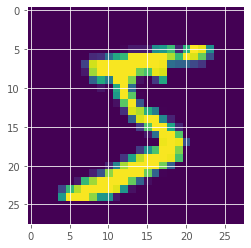

In [5]:
fig, ax = plt.subplots()
ax.imshow(mnist_tr_x[0].reshape(28,28))

## Data Preprocessing

We convert the labels to their one-hot representation. 
This is the best way to run multi-class classification with Falkon which minimizes the squared error

In [6]:
# one-hot labels
A = torch.eye(10, dtype=torch.float32)
mnist_tr_y = A[mnist_tr_y.to(torch.long), :]
mnist_ts_y = A[mnist_ts_y.to(torch.long), :]

In [7]:
def classif_error(y_true, y_pred):
    y_true = torch.argmax(y_true, dim=1)
    y_pred = torch.argmax(y_pred, dim=1)
    err = y_true.flatten() != y_pred.flatten()
    return torch.mean(err.to(torch.float32))

## Run Falkon

There are a few parameters which need to be provided to the algorithm

 - The `FalkonOptions` class is used to provide non-standard tuning knobs. It allows to, for example, tune the amount of GPU memory the algorithm can use, adjust the convergence tolerance, and decide whether certain parts of the algorithm are computed on CPU or GPU. 
     
     It can be used with default parameters for most purposes!
     
 - The **kernel** is the most important choice which depends on the data at hand. We use the `GaussianKernel` which is the most common option and initialize it with a length-scale of 15.
 
 - The **penalty** determines the amount of regularization. A higher value corresponds to more regularization.
 
 - The **number of centers** `M` strongly influences the time needed for fitting. By default the centers
     are chosen uniformly at random.

In [8]:
options = falkon.FalkonOptions(use_cpu=True)
kernel = falkon.kernels.GaussianKernel(sigma=15)
flk = falkon.Falkon(kernel=kernel, 
                    penalty=1e-8,
                    M=1000, 
                    maxiter=10,
                    options=options,
                    error_every=1,
                    error_fn=classif_error)

In [9]:
_ = flk.fit(mnist_tr_x, mnist_tr_y)

Iteration   1 - Elapsed 0.55s - training error: 0.11998333
Iteration   2 - Elapsed 1.02s - training error: 0.07140000
Iteration   3 - Elapsed 1.50s - training error: 0.05766667
Iteration   4 - Elapsed 1.98s - training error: 0.05121667
Iteration   5 - Elapsed 2.46s - training error: 0.04776667
Iteration   6 - Elapsed 2.95s - training error: 0.04556667
Iteration   7 - Elapsed 3.45s - training error: 0.04376667
Iteration   8 - Elapsed 3.93s - training error: 0.04340000
Iteration   9 - Elapsed 4.42s - training error: 0.04286667
Iteration  10 - Elapsed 5.39s - training error: 0.04223333


In [10]:
train_pred = flk.predict(mnist_tr_x)
test_pred = flk.predict(mnist_ts_x)

print("Training error: %.2f%%" % (classif_error(train_pred, mnist_tr_y) * 100))
print("Test error: %.2f%%" % (classif_error(test_pred, mnist_ts_y) * 100))


Training error: 4.22%
Test error: 4.13%
